# Content-Based Recommender

This section involves building a simple content-based recommender system for artists. Content-based filtering involves making reecommendations based on item features. For this dataset, we have limited item features, only taggings made by the users. Last.fm allows users to tag artists with keywords and our dataset contains this user-artist tagging information. These keywords can be anything, but are usually relective of genre or sentiment.

The recommender built below takes an artist as input and outputs a list of similar artists based only on the tags received by each artists. There are too many tags to one-hot-encode all of them. Instead I decided on a TF-IDF approach to convert the set of tags for each artists into numerical values. After performing TF-IDF vectorization I was able to compute a cosine similarity matrix. The recommender system works by simply recommending the artists with the highest similarity scores to the inputted artist.

## Outline
  1. TF-IDF of Tag List
  1. Calculate Similarity Matrix
  1. Recommender
  1. Sanity Check

## Import required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import warnings
warnings.filterwarnings('ignore')

## Read in data

In [2]:
artist_features = pd.read_csv('..\\data\\processed\\artist_features.csv',index_col=0)

**Filter out artists with no tags**  
This method finds similarity based on tags. Therefore, artists that have not been tagged at all can not compared using tags. We will fiter out all artists that have no tags.

In [3]:
artist_features = artist_features[artist_features['peak_year'].notna()]

**Convert all_tags feature to string**  
all_tags is currently stored as a list of strings. Let's convert this into a space seperated string.

In [4]:
artist_features.all_tags = artist_features.all_tags.apply(lambda x: ' '.join(literal_eval(x)))

In [5]:
artist_features.all_tags.head(3)

0    weeabo jrock visualkei betterthanladygaga goth...
1    german seenlive darkwave industrial gothic amb...
2    blackmetal norwegianblackmetal truenorwegianbl...
Name: all_tags, dtype: object

## TF-IDF for tags
Term Frequency-Inverse Document Frequency (TF-IDF) is a technique that can be used to quantify textual data. Term frequency measures the frequency of a word in a document. Inverse document frequency is a measure of how common or rare a word is across the entire dataset. When combined TF-IDF increases proportionally to the occurances of a word in a document, but is offset by the number of documnets that contain that word. TF-IDF can be used to compute a score that is indicative of the importance of each word within the document and the corpus.

We will apply TF-IDF vectorization to all_tags. This will transform the all_tags column to numerical data. Then we will be able to compare the values for different artists and calculate their similarity based on some form of a similarity score.


In [6]:
tfidf = TfidfVectorizer()

#Construct the required TF-IDF matrix by applying the fit_transform method on the all_tags feature
all_tags_matrix = tfidf.fit_transform(artist_features['all_tags'])

#Output the shape of tfidf_matrix
all_tags_matrix.shape

# Map Matrix Index to Artist Name
mapping = pd.Series(artist_features.index,index = artist_features['name'])

In [7]:
all_tags_matrix

<12133x9396 sparse matrix of type '<class 'numpy.float64'>'
	with 106845 stored elements in Compressed Sparse Row format>

## Similarity Matrix

We now have a TF-IDF feature matrix for all of the artists. Every artist has 9,396 featuress (tag words). In order to find the similarity between the artists, we will use cosine_similarity. The linear_kernel function will compute the cosine_similarity for us.

In [8]:
similarity_matrix = linear_kernel(all_tags_matrix,all_tags_matrix)

In [9]:
similarity_df = pd.DataFrame(similarity_matrix, columns = artist_features['name'], index = artist_features['name'])
similarity_df.head(3)

name               MALICE MIZER  Diary of Dreams  Carpathian Forest  \
name                                                                  
MALICE MIZER            1.00000          0.09213                0.0   
Diary of Dreams         0.09213          1.00000                0.0   
Carpathian Forest       0.00000          0.00000                1.0   

name               Moi dix Mois  Bella Morte  Moonspell  Marilyn Manson  \
name                                                                      
MALICE MIZER           0.436071     0.125768   0.068878        0.029499   
Diary of Dreams        0.081005     0.395459   0.250002        0.127415   
Carpathian Forest      0.000000     0.000000   0.067779        0.000000   

name               DIR EN GREY  Combichrist   Grendel  ...  \
name                                                   ...   
MALICE MIZER          0.555061     0.000000  0.000000  ...   
Diary of Dreams       0.095416     0.068551  0.096065  ...   
Carpathian Forest     0.000000     0.000000  0.000000  ...   

name               Electrosoul System  Nostalgia 77  The Young Gods  \
name                                                                  
MALICE MIZER                      0.0           0.0             0.0   
Diary of Dreams                   0.0           0.0             0.0   
Carpathian Forest                 0.0           0.0             0.0   

name               Wiseblood  LOSTFREEQ  Ciccone Youth  Apollo 440  \
name                                                                 
MALICE MIZER             0.0   0.000000            0.0    0.000000   
Diary of Dreams          0.0   0.050611            0.0    0.044474   
Carpathian Forest        0.0   0.000000            0.0    0.000000   

name               Die Krupps  Diamanda GalÃ¡s  Oz Alchemist  
name                                                          
MALICE MIZER         0.000000              0.0      0.000000  
Diary of Dreams      0.166139              0.0      0.034243  
Carpathian Forest    0.000000              0.0      0.000000  

[3 rows x 12133 columns]

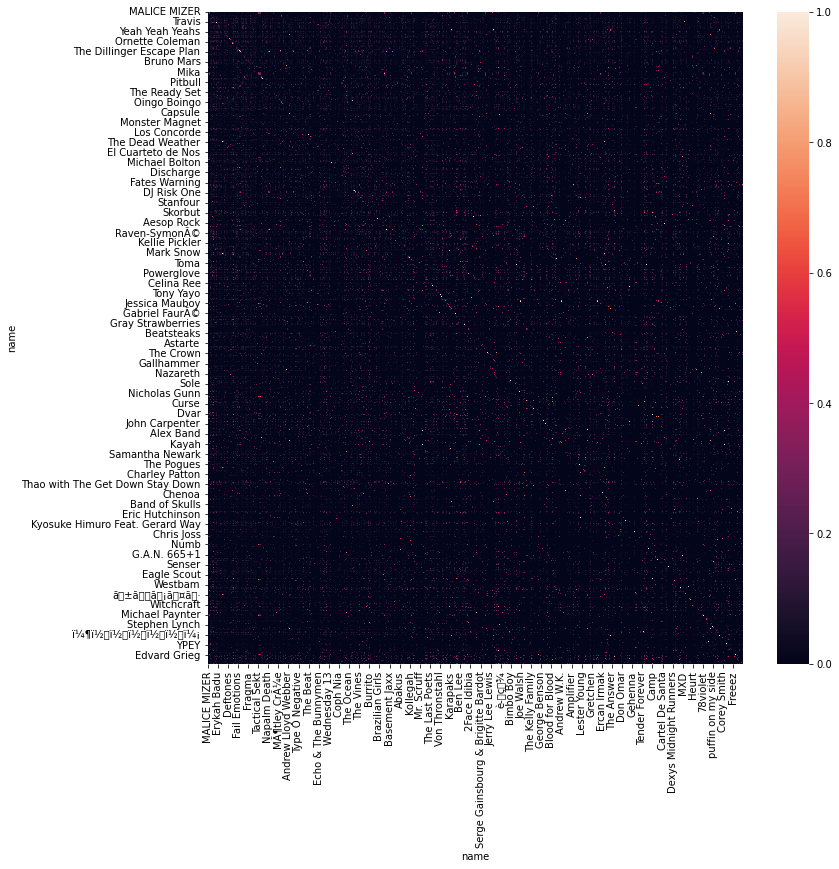

In [10]:
plt.figure(figsize=(12,12))
sns.heatmap(similarity_df)
plt.show()

The heatmap is mostly dark meaning that most artist pairs have a low similarity between the TF-IDF scores for their tags. However, there are some bright pixels which illustrates that some artists do have very similar tags. The line of bright pixels going from the top left corner to the bottom right corner captures the similarity between artists and themselves, which is always 1. As this is a large matrix (9396 x 9396), it is not possible to visualise the matrix in a manner where can clearly identify which artists have similar tags.

## Recommender Function

Now, we will make a recommender function that recommends artists using cosine_similarity. The function will take an aritst name as input and identify the top 10 similar artists using the cosine similarity matrix.

In [11]:
def recommend_artists_based_on_tags(artist_input, k):
    artist_index = mapping[artist_input]
    #get similarity values with other artists
    #similarity_score is the list of index and similarity matrix
    similarity_score = list(enumerate(similarity_matrix[artist_index]))
    #sort in descending order the similarity score of artist inputted with all the other artists
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    # Get the scores of the k most similar movies. Ignore the first movie.
    similarity_score = similarity_score[1:k]
    #return movie names using the mapping series
    artist_indices = [i[0] for i in similarity_score]
    return (artist_features['name'].iloc[artist_indices])

In [12]:
recommend_artists_based_on_tags('The Beatles', 10)

1762            Rita Lee
9881         Karyn White
9668     Freddie Jackson
10727        Keith Sweat
2526     Vanessa Carlton
4871      Glenn Medeiros
334                 Cher
9885       Patti LaBelle
5619              Devdas
Name: name, dtype: object

The above 10 recommendations for users who like The Beatles do not appear to be particularly relevant. The recommendations are based on artists who have received similar taggings to The Beatles. This approach purely uses tag features about the artists. It does not take into account how popular or unpopular the artists are. For this reason, the recommendations are poor and would likely be of little interest to users. Although this method alone would not make a good recommender system, it could still prove useful if combined with a collaborative filtering approach.

## Sanity check similarity scores

It is hard to quantify the potential usefulness of this method for a hybrid approach. To determine if this approach could add value, we will look at the similariy scores for  well known artist pairs. Before we do that though, we will calculate the mean similarity score of the entire similarity matrix. It is important to know this so we can judge whether a particular pair has a relatively high or low similarity score.

In [13]:
sim_mean = similarity_df.to_numpy().mean()
print('Mean similarity score: ', sim_mean)

Mean similarity score:  0.01383527847128692


**U2 & Coldplay**

In [14]:
similarity_df[similarity_df.index == 'U2']['Coldplay']['U2']

0.22446369776706124

**U2 & Lady Gaga**

In [15]:
similarity_df[similarity_df.index == 'U2']['Lady Gaga']['U2']

0.08808980506392858

**Lady Gaga & Katy Perry**

In [16]:
similarity_df[similarity_df.index == 'Katy Perry']['Lady Gaga']['Katy Perry']

0.24031142443152187

**Katy Perry & Luciano Pavarotti**

In [17]:
similarity_df[similarity_df.index == 'Luciano Pavarotti']['Katy Perry']['Luciano Pavarotti']

0.0

**Luciano Pavarotti & Andrea Bocelli**

In [18]:
similarity_df[similarity_df.index == 'Andrea Bocelli']['Luciano Pavarotti']['Andrea Bocelli']

0.22851920014637395

Above are the similarity scores for pairs of artists that I would either associate as similar or dissimilar artists. The results are promising, each artist pair that I would identify as similar have a cosine similarity score of above 0.22. Meanwhile, the artist pairs I would label as disimilar have scores below 0.89. U2 and Coldplay are both European rock bands from the same era, it is reasonable to think that they received similar taggings. U2 and Lady Gaga are less similar, however there were both popular around the same time. Lady Gaga and Katy Perry have the highest similarity score of the above examples, which is unsurprising as they are both popular female pop artists from the same time period. Katy Perry and Luciano Pavarotti, the most extreme artist pair I could think of, have a similarty score of 0. Meanwhile, Luciano Pavarotti and Andrea Bocelli,two Italian opera tenors, had a relatively high similarity score of 0.23. While the above examples are not representative of the entire dataset they are indicative that this content-based recommender can identify similar artists based solely on tags. 

## Conclusion

It is clear that this system on its own would make a poor recommender system. However, the tags received by an artist are informative and can be used to identify similar artists. Through TF-IDF we captured information from each unique tag received by the artist. By keeping all tags and representing them in a vector space we were able assess similarity of artists. A content-based similarity matrix such as this one could be used to improve the results of a collaborative filtering recommender system. Uunfortunately, due to time constraits, I am unable to integrate this method with the previous collaborative approach to form a hybrid.